In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import prim
import seaborn as sns
from sklearn import mixture
import os
#from clustering_and_prim_tools import *
#from zipfile import ZipFile

In [3]:
%matplotlib inline

In [4]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [5]:
myfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/river_floods/"

In [6]:
undiscounted = pd.read_csv(myfolder+"undiscounted_data_merged.csv")

In [7]:
countries = pd.read_excel(myfolder+"State_names_Countries.xlsx")

In [8]:
gdp = pd.read_excel(myfolder+"GDP_Julie.xlsx")

This file below is used to correct the names of the countries if they are not the same as in the WB codes file

In [9]:
any_name_to_wb = pd.read_csv(myfolder+"any_name_to_wb_name.csv")

In [10]:
gdp.columns

Index([        'FID',          2010,  'Unnamed: 2', 'SSP1 - 2030',
       'SSP2 - 2030', 'SSP3 - 2030', 'SSP4 - 2030', 'SSP5 - 2030',
        'Unnamed: 8', 'SSP1 - 2050', 'SSP2 - 2050', 'SSP3 - 2050',
       'SSP4 - 2050', 'SSP5 - 2050', 'Unnamed: 14', 'SSP1 - 2080',
       'SSP2 - 2080', 'SSP3 - 2080', 'SSP4 - 2080', 'SSP5 - 2080'],
      dtype='object')

I have to interpolate the GDPs to have a value every year (this is what the next lines are about)

In [11]:
gdp_2030 = gdp[["FID",'SSP1 - 2030', 'SSP2 - 2030', 'SSP3 - 2030', 'SSP4 - 2030','SSP5 - 2030']].rename(columns={'SSP1 - 2030':"ssp1",\
                                                                                                            'SSP2 - 2030':"ssp2",\
                                                                                                            'SSP3 - 2030':"ssp3",\
                                                                                                            'SSP4 - 2030':"ssp4",\
                                                                                                            'SSP5 - 2030':"ssp5"})

gdp_2030 = gdp_2030.set_index("FID")
gdp_2030.columns.name="ssp"
gdp_2030 = gdp_2030.stack()

gdp_2030 = gdp_2030.reset_index().rename(columns={0:2030})

In [12]:
gdp_2050 = gdp[["FID",'SSP1 - 2050', 'SSP2 - 2050', 'SSP3 - 2050', 'SSP4 - 2050','SSP5 - 2050']].rename(columns={'SSP1 - 2050':"ssp1",\
                                                                                                            'SSP2 - 2050':"ssp2",\
                                                                                                            'SSP3 - 2050':"ssp3",\
                                                                                                            'SSP4 - 2050':"ssp4",\
                                                                                                            'SSP5 - 2050':"ssp5"})

gdp_2050 = gdp_2050.set_index("FID")
gdp_2050.columns.name="ssp"
gdp_2050 = gdp_2050.stack()

gdp_2050 = gdp_2050.reset_index().rename(columns={0:2050})

In [13]:
gdp_all_years = gdp_2030.merge(gdp_2050,on=["FID","ssp"],how="outer").merge(gdp[["FID",2010]],on="FID",how="outer")

In [14]:
gdp_all_years = gdp_all_years.set_index(["FID","ssp"])
gdp_all_years.columns.name="year"
gdp_all_years = gdp_all_years.stack()

In [15]:
gdp_all_years = gdp_all_years.reset_index().rename(columns={0:'gdp'})

In [16]:
gdp_all_years = gdp_all_years.set_index(["FID","ssp","year"]).sort_index(level=["FID","ssp","year"])

In [17]:
test = gdp_all_years.unstack(level=["FID","ssp"]).reindex(range(2010,2051))

In [18]:
new_gdp = test.interpolate(axis=0)

In [19]:
final_annual_gdp = new_gdp.unstack().reset_index().drop("level_0",axis=1).rename(columns={0:"gdp"})

In [20]:
final_annual_gdp.sample(3)

FID   ssp  year           gdp
630761  3076  ssp5  2027  6.607909e+09
201512   982  ssp5  2048  1.141374e+11
771783  3764  ssp4  2050  3.499482e+07

In [21]:
final_annual_gdp = final_annual_gdp.merge(countries,on="FID",how="left")

In [22]:
final_annual_gdp = final_annual_gdp.set_index(["FID","Country name","ssp","year"]).gdp.sum(level=["Country name","ssp","year"])

In [23]:
codes = pd.read_csv(myfolder+"wbccodes2014.csv")

In [24]:
codes.loc[codes.country_name=="Uruguay",:]

country country_name wbregion wbregionname wbincome          wbincomename  \
199     URY      Uruguay      YHI  High Income      HIX  High income: nonOECD   

    wblending wbhipc  
199      IBRD    NaN

In [25]:
undiscounted = undiscounted.dropna().reset_index()

In [26]:
undiscounted = undiscounted.merge(countries.rename(columns={"FID":"ID"}),on="ID",how="left")

In [27]:
undiscounted = undiscounted.merge(any_name_to_wb.rename(columns={"any":"Country name"}),on="Country name")

In [28]:
undiscounted_c = undiscounted.set_index(["ID","wb_name","construction_cost","objective","gcm","rcp","ssp","current_std"]).sum(level=["wb_name","construction_cost","objective","gcm","rcp","ssp","current_std"])

In [29]:
undiscounted_c = undiscounted_c.reset_index().rename(columns={"wb_name":"country_name"}).merge(codes,on="country_name",how="left")

In [30]:
undiscounted_c.loc[undiscounted_c.wbregion.isnull()].country_name.unique()

array(['Taiwan'], dtype=object)

Drops high income countries

In [31]:
undiscounted_c.loc[undiscounted_c.wbregion!="YHI"].country_name.unique().size

119

In [35]:
newfile = undiscounted_c.set_index(["wbregionname","country_name","construction_cost","objective","gcm","rcp","ssp","current_std"]).infra_cost.sum(level=["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std"])

In [36]:
final_annual_gdp = final_annual_gdp.reset_index().merge(any_name_to_wb.rename(columns={"any":"Country name"}),on="Country name")

In [37]:
final_annual_gdp = final_annual_gdp.rename(columns={"wb_name":"country_name"}).merge(codes,on="country_name",how="left")

In [38]:
gdp_reg = final_annual_gdp.set_index(["wbregionname","ssp","country_name","year"]).gdp.sum(level=["wbregionname","ssp","year"])

In [39]:
gdp_reg.to_frame().to_csv(myfolder+"region_gdp.csv")

### For Vivien Foster: Vietnam

In [34]:
vtn = undiscounted_c.loc[undiscounted_c.country_name=="Vietnam",:]

In [40]:
vtn = vtn.reset_index().merge(final_annual_gdp.reset_index(),on=["country_name","ssp"])

In [41]:
vtn["annual_cost"] = vtn.infra_cost/30
vtn.loc[vtn.year<2021,"annual_cost"] = 0
vtn.loc[vtn.year>2050,"annual_cost"] = 0

In [43]:
vtn = vtn.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"])
vtn["cumcost"] = vtn.annual_cost.unstack("year").cumsum(axis=1).stack("year")
vtn["maintenance_cost"] = 1/100*vtn["cumcost"]

In [44]:
vtn["annual_cost_pc"]       = vtn.annual_cost/vtn.gdp
vtn["maintenance_cost_pc"]  = vtn.maintenance_cost/vtn.gdp

C:\ProgramData\Anaconda3\envs\Julie1\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\envs\Julie1\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


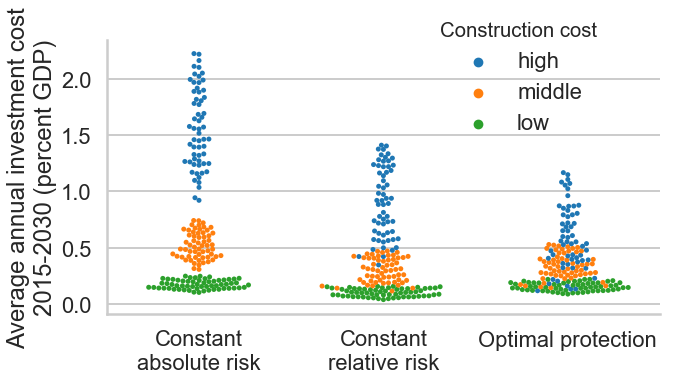

In [46]:
test = vtn[["annual_cost_pc","maintenance_cost_pc"]].reset_index().copy()
test = test.loc[(test.year>2014)&(test.year<2031)]
test = test.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])
test = test.reset_index()
#test = test.loc[(test.construction_cost=="middle")]
test = test.loc[((test.ssp=='ssp5')|(test.ssp=='ssp3')|(test.ssp=='ssp2')),:]
test["annual_cost_pc"] = 100*test["annual_cost_pc"]
test["maintenance_cost_pc"] = 100*test["maintenance_cost_pc"]
test["objective"] = test.objective.replace({"car":"Constant\nabsolute risk","crr":"Constant\nrelative risk","opt":"Optimal protection"})

g = sns.factorplot(x='objective',y='annual_cost_pc', hue= 'construction_cost', data=test, kind="swarm",dodge=False, size=6, aspect=1.6,\
                  legend=False)

g.set_axis_labels("", "Average annual investment cost\n2015-2030 (percent GDP)")
g.add_legend(title="Construction cost",bbox_to_anchor=(0.7, 0.7), borderaxespad=0.)

In [45]:
best_scenario = vtn.reset_index().copy()

select = (best_scenario.objective=="opt")&(best_scenario.ssp=="ssp2")&\
(best_scenario.construction_cost=="middle")&(best_scenario.year>2014)&(best_scenario.year<2031)

best_scenario.loc[select,:].set_index(["gcm","rcp","year"])[["annual_cost_pc","maintenance_cost_pc"]].mean(level="rcp")

annual_cost_pc  maintenance_cost_pc
rcp                                        
rcp2p6        0.002654             0.000137
rcp4p5        0.003824             0.000197
rcp6p0        0.003701             0.000191
rcp8p5        0.004358             0.000225

In [47]:
low_scenario = vtn.reset_index().copy()

select = (low_scenario.objective=="opt")&(low_scenario.ssp=="ssp2")&\
(low_scenario.construction_cost=="low")&(low_scenario.year>2014)&(low_scenario.year<2031)

low_scenario.loc[select,:].set_index(["gcm","rcp","year"])[["annual_cost_pc","maintenance_cost_pc"]].mean(level="rcp")

annual_cost_pc  maintenance_cost_pc
rcp                                        
rcp2p6        0.001270             0.000066
rcp4p5        0.001708             0.000088
rcp6p0        0.001682             0.000087
rcp8p5        0.001915             0.000099

In [48]:
high_scenario = vtn.reset_index().copy()

select = (high_scenario.objective=="car")&(high_scenario.ssp=="ssp2")&\
(high_scenario.construction_cost=="high")&(high_scenario.year>2014)&(high_scenario.year<2031)

high_scenario.loc[select,:].set_index(["gcm","rcp","year"])[["annual_cost_pc","maintenance_cost_pc"]].mean(level="rcp")

annual_cost_pc  maintenance_cost_pc
rcp                                        
rcp2p6        0.012796             0.000661
rcp4p5        0.017221             0.000889
rcp6p0        0.016996             0.000878
rcp8p5        0.019341             0.000999

### re-organizes the data as instructed by Philip Ward

In [41]:
newfile = newfile.reset_index().merge(gdp_reg.reset_index(),on=["wbregionname","ssp"])

In [42]:
newfile["annual_cost"] = newfile.infra_cost/30

In [43]:
newfile.loc[newfile.year<2021,"annual_cost"] = 0
newfile.loc[newfile.year>2050,"annual_cost"] = 0

In [44]:
newfile = newfile.set_index(["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std","year"])

In [45]:
newfile["cumcost"] = newfile.annual_cost.unstack("year").cumsum(axis=1).stack("year")

In [46]:
newfile["maintenance_cost"] = 1/100*newfile["cumcost"]

In [47]:
newfile["total_annual_cost"] = newfile["annual_cost"]+newfile["maintenance_cost"]

In [48]:
newfile.sample(4)

infra_cost  \
wbregionname               construction_cost objective gcm          rcp    ssp  current_std year                 
Middle East & North Africa low               car       mirocesmchem rcp4p5 ssp3 middle      2021  8.110792e+10   
                           middle            car       noresm1m     rcp4p5 ssp2 middle      2035  6.358742e+11   
High Income                middle            car       ipslcm5alr   rcp4p5 ssp1 middle      2022  3.475068e+12   
Middle East & North Africa high              car       gfdlesm2m    rcp8p5 ssp5 middle      2045  8.993991e+11   

                                                                                                           gdp  \
wbregionname               construction_cost objective gcm          rcp    ssp  current_std year                 
Middle East & North Africa low               car       mirocesmchem rcp4p5 ssp3 middle      2021  3.655933e+12   
                           middle            car       noresm1m     rcp4p5 ssp2 middle      2035  6.132578e+12   
High Income                middle            car       ipslcm5alr   rcp4p5 ssp1 middle      2022  5.228988e+13   
Middle East & North Africa high              car       gfdlesm2m    rcp8p5 ssp5 middle      2045  1.184166e+13   

                                                                                                   annual_cost  \
wbregionname               construction_cost objective gcm          rcp    ssp  current_std year                 
Middle East & North Africa low               car       mirocesmchem rcp4p5 ssp3 middle      2021  2.703597e+09   
                           middle            car       noresm1m     rcp4p5 ssp2 middle      2035  2.119581e+10   
High Income                middle            car       ipslcm5alr   rcp4p5 ssp1 middle      2022  1.158356e+11   
Middle East & North Africa high              car       gfdlesm2m    rcp8p5 ssp5 middle      2045  2.997997e+10   

                                                                                                       cumcost  \
wbregionname               construction_cost objective gcm          rcp    ssp  current_std year                 
Middle East & North Africa low               car       mirocesmchem rcp4p5 ssp3 middle      2021  2.703597e+09   
                           middle            car       noresm1m     rcp4p5 ssp2 middle      2035  3.179371e+11   
High Income                middle            car       ipslcm5alr   rcp4p5 ssp1 middle      2022  2.316712e+11   
Middle East & North Africa high              car       gfdlesm2m    rcp8p5 ssp5 middle      2045  7.494993e+11   

                                                                                                  maintenance_cost  \
wbregionname               construction_cost objective gcm          rcp    ssp  current_std year                     
Middle East & North Africa low               car       mirocesmchem rcp4p5 ssp3 middle      2021      2.703597e+07   
                           middle            car       noresm1m     rcp4p5 ssp2 middle      2035      3.179371e+09   
High Income                middle            car       ipslcm5alr   rcp4p5 ssp1 middle      2022      2.316712e+09   
Middle East & North Africa high              car       gfdlesm2m    rcp8p5 ssp5 middle      2045      7.494993e+09   

                                                                                                  total_annual_cost  
wbregionname               construction_cost objective gcm          rcp    ssp  current_std year                     
Middle East & North Africa low               car       mirocesmchem rcp4p5 ssp3 middle      2021       2.730633e+09  
                           middle            car       noresm1m     rcp4p5 ssp2 middle      2035       2.437518e+10  
High Income                middle            car       ipslcm5alr   rcp4p5 ssp1 middle      2022       1.181523e+11  
Middle East & North Africa high              car       gfdles

In [49]:
all_dev = newfile.drop("High Income", level="wbregionname").sum(level=["construction_cost","objective","gcm","rcp","ssp","current_std","year"])

In [50]:
all_dev["total_annual_cost_pc"] = all_dev.total_annual_cost/all_dev.gdp
all_dev["annual_cost_pc"]       = all_dev.annual_cost/all_dev.gdp
all_dev["maintenance_cost_pc"]  = all_dev.maintenance_cost/all_dev.gdp

In [51]:
newfile["total_annual_cost_pc"] = newfile.total_annual_cost/newfile.gdp
newfile["annual_cost_pc"]       = newfile.annual_cost/newfile.gdp
newfile["maintenance_cost_pc"]  = newfile.maintenance_cost/newfile.gdp

## Numbers for the report

This analysis contains more SSPs and climate scenarios than the coastal protection one. For comparison purposes, I only select the SSPs that are also in the coastal protection study (2, 3 and 5)

In [53]:
pic = all_dev["maintenance_cost_pc"].reset_index().copy()
pic = pic.loc[(pic.year>2014)&(pic.year<2031),:]
pic = pic.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])
pic = pic.reset_index()
pic = pic.loc[((pic.ssp=='ssp5')|(pic.ssp=='ssp3')|(pic.ssp=='ssp2')),:]
pic = pic.loc[(pic.construction_cost=="middle")]

100*pic.maintenance_cost_pc.describe()

count    18000.000000
mean         0.016992
std          0.010169
min          0.002433
25%          0.008864
50%          0.013053
75%          0.026859
max          0.042139
Name: maintenance_cost_pc, dtype: float64

In [54]:
pic = all_dev["annual_cost_pc"].reset_index().copy()
pic = pic.loc[(pic.year>2014)&(pic.year<2031),:]
pic = pic.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])
pic = pic.reset_index()
pic = pic.loc[((pic.ssp=='ssp5')|(pic.ssp=='ssp3')|(pic.ssp=='ssp2')),:]

100*pic.annual_cost_pc.describe()

count    54000.000000
mean         0.453605
std          0.521038
min          0.036551
25%          0.108433
50%          0.210340
75%          0.584080
max          2.440367
Name: annual_cost_pc, dtype: float64

We restrict the analysis to the middle assumption for construction costs 

In [56]:
pic = all_dev["annual_cost_pc"].reset_index().copy()
pic = pic.loc[(pic.year>2014)&(pic.year<2031),:]
pic = pic.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])
pic = pic.reset_index()
pic = pic.loc[((pic.ssp=='ssp5')|(pic.ssp=='ssp3')|(pic.ssp=='ssp2')),:]
pic = pic.loc[(pic.construction_cost=="middle")]

100*pic.annual_cost_pc.describe()

count    18000.000000
mean         0.328504
std          0.196538
min          0.046844
25%          0.170693
50%          0.251622
75%          0.517992
max          0.813456
Name: annual_cost_pc, dtype: float64

In [57]:
pic.objective.unique()

array(['car', 'crr', 'opt'], dtype=object)

Description per investment strategy (objective)

In [58]:
pic = all_dev["annual_cost_pc"].reset_index().copy()
pic = pic.loc[(pic.year>2014)&(pic.year<2031),:]
pic = pic.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])
pic = pic.reset_index()
pic = pic.loc[((pic.ssp=='ssp5')|(pic.ssp=='ssp3')|(pic.ssp=='ssp2')),:]
pic = pic.loc[(pic.construction_cost=="middle")&(pic.objective=="opt")]

100*pic.annual_cost_pc.describe()

count    6000.000000
mean        0.141791
std         0.051985
min         0.046844
25%         0.105006
50%         0.143457
75%         0.178800
max         0.265070
Name: annual_cost_pc, dtype: float64

In [59]:
pic = all_dev["annual_cost_pc"].reset_index().copy()
pic = pic.loc[(pic.year>2014)&(pic.year<2031),:]
pic = pic.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])
pic = pic.reset_index()
pic = pic.loc[((pic.ssp=='ssp5')|(pic.ssp=='ssp3')|(pic.ssp=='ssp2')),:]
pic = pic.loc[(pic.construction_cost=="middle")&(pic.objective=="car")]

100*pic.annual_cost_pc.describe()

count    6000.000000
mean        0.578888
std         0.078548
min         0.453858
25%         0.518174
50%         0.563513
75%         0.632669
max         0.813456
Name: annual_cost_pc, dtype: float64

## Preferred scenario

In [61]:
best_scenario = all_dev.reset_index().copy()

select = (best_scenario.objective=="opt")&(best_scenario.ssp=="ssp2")&(best_scenario.rcp=="rcp8p5")&\
(best_scenario.construction_cost=="middle")&(best_scenario.year>2014)&(best_scenario.year<2031)

100*best_scenario.loc[select,:].set_index(["gcm","year"])[["annual_cost_pc","maintenance_cost_pc"]].mean(level="gcm").mean()

annual_cost_pc         0.179653
maintenance_cost_pc    0.009306
dtype: float64

## Preferred scenario by region

In [62]:
best_scenario = newfile.reset_index().copy()

select = (best_scenario.objective=="opt")&(best_scenario.ssp=="ssp2")&(best_scenario.rcp=="rcp8p5")&\
(best_scenario.construction_cost=="middle")&(best_scenario.year>2014)&(best_scenario.year<2031)

100*best_scenario.loc[select,:].set_index(["wbregionname","gcm","year"])[["annual_cost_pc","maintenance_cost_pc"]].mean(level=["wbregionname"])

annual_cost_pc  maintenance_cost_pc
wbregionname                                                   
South Asia                        0.372763             0.019231
Sub-Saharan Africa                0.539458             0.027908
Europe & Central Asia             0.037059             0.001949
High Income                       0.037943             0.002026
Latin America & Caribbean         0.109690             0.005778
East Asia & Pacific               0.116886             0.006014
Middle East & North Africa        0.089476             0.004685

## Figure 5.4

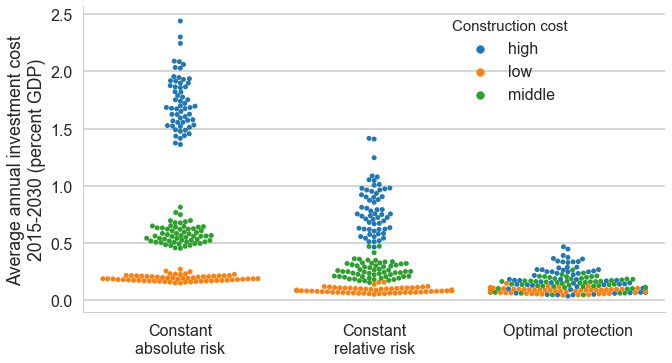

In [270]:
test = all_dev[["annual_cost_pc","total_annual_cost_pc","maintenance_cost_pc"]].reset_index().copy()
test = test.loc[(test.year>2014)&(test.year<2031)]
test = test.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])
test = test.reset_index()
#test = test.loc[(test.construction_cost=="middle")]
test = test.loc[((test.ssp=='ssp5')|(test.ssp=='ssp3')|(test.ssp=='ssp2')),:]
test["annual_cost_pc"] = 100*test["annual_cost_pc"]
test["total_annual_cost_pc"] = 100*test["total_annual_cost_pc"]
test["maintenance_cost_pc"] = 100*test["maintenance_cost_pc"]
test["objective"] = test.objective.replace({"car":"Constant\nabsolute risk","crr":"Constant\nrelative risk","opt":"Optimal protection"})

#test["construction_cost"] = test.construction_cost.replace({"low":"Clow","middle":"Bmedium","high":"Ahigh"})
#test = test.set_index(["construction_cost","objective"]).sort_index(level=["construction_cost","objective"])
#test = test.reset_index()

#test["construction_cost"] = test.construction_cost.apply(lambda x : x[1:])

g = sns.factorplot(x='objective',y='annual_cost_pc', hue= 'construction_cost', data=test, kind="swarm",dodge=False, size=6, aspect=1.6,\
                  legend=False)

g.set_axis_labels("", "Average annual investment cost\n2015-2030 (percent GDP)")
g.add_legend(title="Construction cost",bbox_to_anchor=(0.7, 0.7), borderaxespad=0.)

plt.savefig("riverine_protection_inv_2030_pcGDP_fig54.png",ddpi=300,bbox_inches="tight")
plt.savefig("riverine_protection_inv_2030_pcGDP_fig54.pdf")

In [272]:
test.loc[test.objective=="Optimal protection","annual_cost_pc"].describe()

count    180.000000
mean       0.142106
std        0.085055
min        0.036551
25%        0.078982
50%        0.114701
75%        0.178546
max        0.467188
Name: annual_cost_pc, dtype: float64

In [273]:
test.loc[test.objective=="Constant\nabsolute risk","annual_cost_pc"].describe()

count    180.000000
mean       0.836172
std        0.673226
min        0.151286
25%        0.210894
50%        0.563513
75%        1.553976
max        2.440367
Name: annual_cost_pc, dtype: float64

In [274]:
test.gcm.unique()

array(['gfdlesm2m', 'hadgem2es', 'ipslcm5alr', 'mirocesmchem', 'noresm1m'], dtype=object)

In [277]:
test.loc[test.objective=="Optimal protection","annual_cost_pc"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: annual_cost_pc, dtype: float64

In [278]:
test.loc[test.objective=="Constant\nabsolute risk","annual_cost_pc"].describe()

count    180.000000
mean       0.836172
std        0.673226
min        0.151286
25%        0.210894
50%        0.563513
75%        1.553976
max        2.440367
Name: annual_cost_pc, dtype: float64

In [279]:
test.loc[test.objective=="Optimal protection","total_annual_cost_pc"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: total_annual_cost_pc, dtype: float64

In [280]:
test.loc[test.objective=="Constant\nabsolute risk","total_annual_cost_pc"].describe()

count    180.000000
mean       0.879429
std        0.708054
min        0.159142
25%        0.221747
50%        0.592645
75%        1.634624
max        2.566783
Name: total_annual_cost_pc, dtype: float64

In [281]:
test.loc[test.objective=="Constant\nrelative risk","total_annual_cost_pc"].describe()

count    180.000000
mean       0.402329
std        0.344327
min        0.054408
25%        0.110673
50%        0.264410
75%        0.654003
max        1.488131
Name: total_annual_cost_pc, dtype: float64

In [282]:
test = all_dev[["total_annual_cost_pc"]].reset_index().copy()
test = test.loc[(test.year>2014)&(test.year<2051)]
test = test.set_index(["construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["construction_cost","objective","gcm","rcp","ssp","current_std"])
test = test.reset_index()

In [283]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [284]:
def drivers_from_anova(varin,mydata):
    formula=varin+" ~ construction_cost+objective+gcm+rcp+ssp+current_std"
    olsmodel=ols(formula,data=mydata).fit()
    table=anova_lm(olsmodel)
    table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
    table=table.sort_values(by=['sum_sq'],ascending=False)
    sumvar=0
    drivers=list()
    for var in table.index:
        if var!='Residual':
            drivers.append(var)
            sumvar+=table.loc[var,'sum_sq_pc']
        if len(drivers)==3:
            break
    return drivers,sumvar

In [285]:
drivers,sumvar = drivers_from_anova("total_annual_cost_discounted",all_dev.reset_index())
print(drivers,sumvar)

['construction_cost', 'objective', 'gcm'] 0.349020412194


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [286]:
test.construction_cost.unique()

array(['high', 'low', 'middle'], dtype=object)

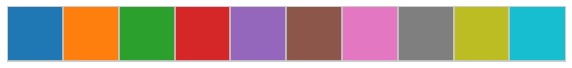

In [287]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [288]:
current_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [289]:
current_palette[2::-1]

[(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

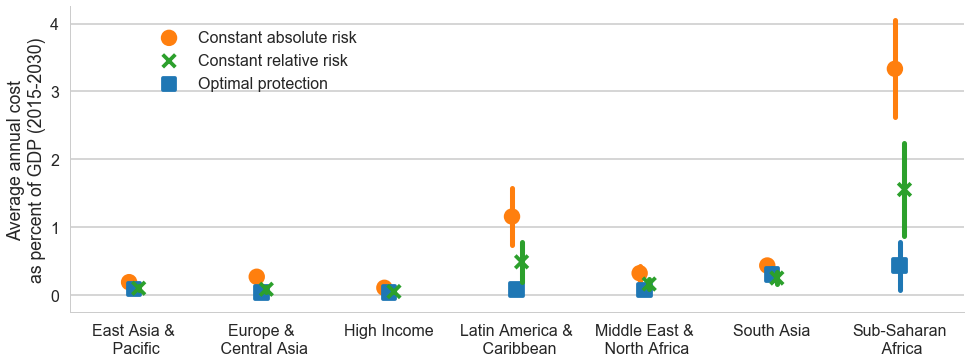

In [290]:
time_horizon = 2030

toplot = newfile.reset_index().copy()
toplot = toplot.loc[(toplot.year>2014)&(toplot.year<time_horizon+1)&(toplot.construction_cost=="middle"),:]
toplot = toplot.set_index(["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std"])
toplot = toplot.reset_index()
toplot['total_annual_cost_pc'] = 100*toplot.total_annual_cost_pc
toplot['maintenance_cost_pc'] = 100*toplot.maintenance_cost_pc
toplot['annual_cost_pc'] = 100*toplot.annual_cost_pc
toplot["wbregionname"] = toplot.wbregionname.str.replace("&","&\n").str.replace("Saharan","Saharan\n")
toplot["objective"] = toplot.objective.replace({"car":"Constant absolute risk","crr":"Constant relative risk","opt":"Optimal protection"})

toplot = toplot.sort_values("objective",ascending=False).sort_values("wbregionname")

g = sns.factorplot(x='wbregionname',y='annual_cost_pc', hue= 'objective', data=toplot, kind="point",dodge=True,join=False,\
                  ci='sd', markers=["o",'s','x'], palette = [current_palette[1],current_palette[0],current_palette[2]], size=6, aspect=2.3,\
                  legend=False)

g.set_axis_labels("", "Average annual cost\nas percent of GDP (2015-{})".format(time_horizon))
g.add_legend(title="",bbox_to_anchor=(0.3, 0.7), borderaxespad=0.)

plt.savefig("river_inv_region_{}pc_all_regions.png".format(time_horizon),ddpi=300,bbox_inches="tight")
plt.savefig("river_inv_region_{}pc_all_regions.pdf".format(time_horizon))

In [291]:
toplot.set_index(["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std"]).mean(level=["wbregionname","objective"]).annual_cost_pc

wbregionname                  objective             
East Asia &\n Pacific         Constant absolute risk    0.190864
                              Constant relative risk    0.101380
                              Optimal protection        0.090372
Europe &\n Central Asia       Constant absolute risk    0.270499
                              Constant relative risk    0.086214
                              Optimal protection        0.042295
High Income                   Constant absolute risk    0.107953
                              Constant relative risk    0.052744
                              Optimal protection        0.035930
Latin America &\n Caribbean   Constant absolute risk    1.157525
                              Constant relative risk    0.490023
                              Optimal protection        0.081932
Middle East &\n North Africa  Constant absolute risk    0.322954
                              Constant relative risk    0.163820
                              Optimal

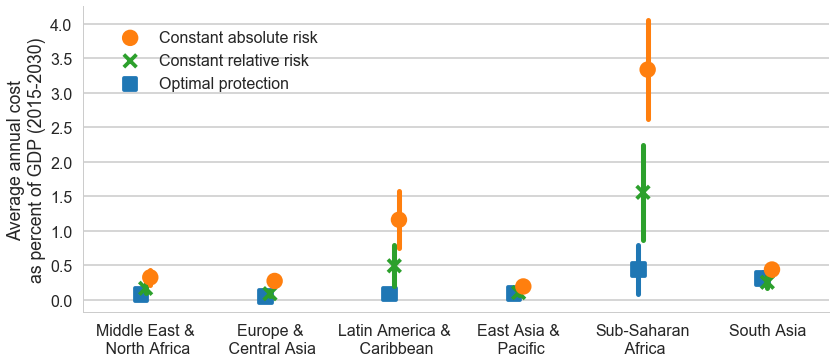

In [292]:
time_horizon = 2030

toplot = newfile.reset_index().copy()
toplot = toplot.loc[(toplot.year>2014)&(toplot.year<time_horizon+1)&(toplot.wbregionname!="High Income")&(toplot.construction_cost=="middle"),:]
toplot = toplot.set_index(["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std"])
toplot = toplot.reset_index()
toplot['total_annual_cost_pc'] = 100*toplot.total_annual_cost_pc
toplot['maintenance_cost_pc'] = 100*toplot.maintenance_cost_pc
toplot['annual_cost_pc'] = 100*toplot.annual_cost_pc
toplot["wbregionname"] = toplot.wbregionname.str.replace("&","&\n").str.replace("Saharan","Saharan\n")
toplot["objective"] = toplot.objective.replace({"car":"Constant absolute risk","crr":"Constant relative risk","opt":"Optimal protection"})

toplot = toplot.sort_values("wbregionname").sort_values("objective",ascending=False)

g = sns.factorplot(x='wbregionname',y='annual_cost_pc', hue= 'objective', data=toplot, kind="point",dodge=True,join=False,\
                  ci='sd', markers=["s",'x','o'], palette = [current_palette[0],current_palette[2],current_palette[1]], size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Average annual cost\nas percent of GDP (2015-{})".format(time_horizon))
g.add_legend(title="",bbox_to_anchor=(0.3, 0.7), borderaxespad=0.)

plt.savefig("river_inv_region_{}pc_dev.png".format(time_horizon),ddpi=300,bbox_inches="tight")
plt.savefig("river_inv_region_{}pc_dev.pdf".format(time_horizon))

In [293]:
toplot = newfile.reset_index().copy()
toplot = toplot.loc[(toplot.year>2014)&(toplot.year<2031)&(toplot.wbregionname!="High Income")&(toplot.construction_cost=="middle")&(toplot.objective=="opt")&((toplot.ssp=='ssp5')|(toplot.ssp=='ssp3')),:]
toplot = toplot.set_index(["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std","year"]).mean(level=["wbregionname","construction_cost","objective","gcm","rcp","ssp","current_std"])
toplot = toplot.reset_index()
toplot['total_annual_cost_pc'] = 100*toplot.total_annual_cost_pc
toplot['maintenance_cost_pc'] = 100*toplot.maintenance_cost_pc
toplot['annual_cost_pc'] = 100*toplot.annual_cost_pc
toplot["wbregionname"] = toplot.wbregionname.str.replace(" ","\n")
toplot["objective"] = toplot.objective.replace({"car":"Constant absolute risk","crr":"Constant relative risk","opt":"Cost minimization"})
toplot["ssp"] = toplot.ssp.replace({"ssp3":"Slow economic growth and urbanization","ssp5":"Fast economic growth and urbanization"})

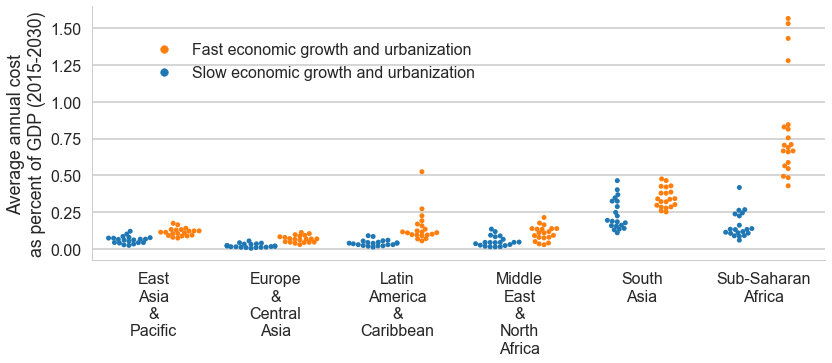

In [294]:
g = sns.factorplot(x='wbregionname',y='total_annual_cost_pc', hue= 'ssp', data=toplot, kind="swarm",dodge=True,\
                  size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Average annual cost\nas percent of GDP (2015-2030)")
g.add_legend(title="",bbox_to_anchor=(0.4, 0.7), borderaxespad=0.)

#plt.savefig("riverine_protection_cost_pc_gdp.png",ddpi=300,bbox_inches="tight")

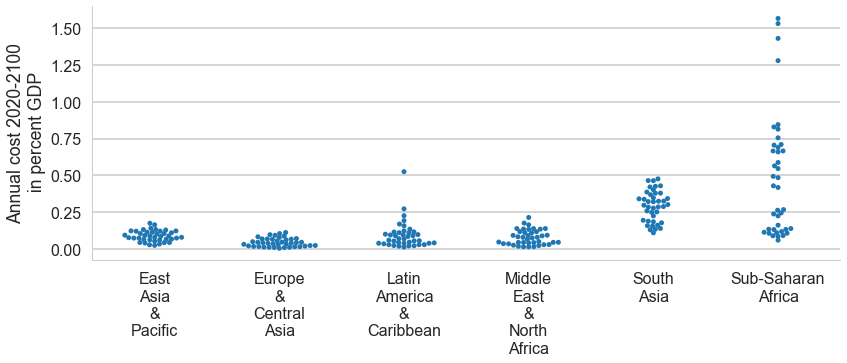

In [295]:
g = sns.factorplot(x='wbregionname',y='total_annual_cost_pc',hue= 'objective', data=toplot, kind="swarm",dodge=True, size=6, aspect=2,\
                  legend=False)

g.set_axis_labels("", "Annual cost 2020-2100\n in percent GDP")